In [53]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Loading Dataset

In [54]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("src/Building_Permits_Large.csv")
print("...Done.")

Loading dataset...


c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3369: DtypeWarning: Columns (18,22,23,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


...Done.


Data Cleaning

In [55]:
mask = dataset['Permit Type'] < 3

filtered_dataset = dataset.loc[mask, :]

In [56]:
filtered_dataset.shape

(15247, 53)

In [57]:
filtered_dataset = filtered_dataset.dropna(subset=['Estimated Cost'])

In [58]:
filtered_dataset['Proposed Construction Type'].value_counts().index

Index([5.0, 1.0, 3.0, 2.0, '5', 4.0, '1', '3', '2', '4', 'III'], dtype='object')

In [59]:
filtered_dataset['Proposed Construction Type'] = filtered_dataset['Proposed Construction Type'].replace('III', '3').fillna(0).astype(float)

In [60]:
filtered_dataset['Zipcode'] = filtered_dataset['Zipcode'].fillna(0).astype(int)

In [61]:
filtered_dataset.shape

(15099, 53)

In [62]:
m1 = filtered_dataset["Estimated Cost"] < 1000000
filtered_dataset = filtered_dataset.loc[m1,:]
#m1b = filtered_dataset["Estimated Cost"] > 50000
#filtered_dataset = filtered_dataset.loc[m1b,:]
filtered_dataset.shape

(11803, 53)

In [63]:
filtered_dataset["Year"]=filtered_dataset["Filed Date"].apply(lambda x : int(x[6:]))
m2 = filtered_dataset["Year"]>1990
filtered_dataset = filtered_dataset.loc[m2,:]
filtered_dataset.shape

(6784, 54)

In [64]:
filtered_dataset["Year"].value_counts()

1991    622
2000    481
1998    401
1999    334
1997    327
1995    312
2001    297
1994    286
2002    286
1996    272
1993    270
2015    258
2005    254
2003    225
1992    223
2006    195
2004    194
2007    175
2014    174
2012    155
2013    136
2010    122
2008    109
2019    102
2016    100
2022     96
2018     84
2021     79
2017     70
2009     61
2020     46
2011     38
Name: Year, dtype: int64

Features selection

In [65]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = [
    "Permit Type",
    "Year",
    "Unit",
    "Number of Proposed Stories", 
    "Plansets", 
    "Proposed Construction Type", 
    "Neighborhoods - Analysis Boundaries", 
    "Zipcode"
]

target_variable = "Estimated Cost"

X = filtered_dataset.loc[:,features_list]
Y = filtered_dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())


Separating labels from features...
...Done.

Y : 
1      50000.0
2      50000.0
39    900000.0
65    550000.0
80    800000.0
Name: Estimated Cost, dtype: float64

X :
    Permit Type  Year  Unit  Number of Proposed Stories  Plansets  \
1             2  2020   NaN                         1.0       2.0   
2             2  2020   NaN                         1.0       2.0   
39            2  2018   NaN                         4.0       2.0   
65            2  2019   NaN                         4.0       2.0   
80            2  2019   NaN                         4.0       2.0   

    Proposed Construction Type Neighborhoods - Analysis Boundaries  Zipcode  
1                          5.0                        Inner Sunset    94122  
2                          5.0                        Inner Sunset    94122  
39                         5.0                            Nob Hill    94108  
65                         5.0                        Hayes Valley    94102  
80                         5

In [66]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Permit Type', 'Year', 'Unit', 'Number of Proposed Stories', 'Plansets', 'Proposed Construction Type', 'Zipcode']
Found categorical features  ['Neighborhoods - Analysis Boundaries']


In [67]:
numeric_features = ['Permit Type', 'Number of Proposed Stories','Unit',  'Plansets', 'Proposed Construction Type'] 
categorical_features = ['Neighborhoods - Analysis Boundaries', 'Zipcode','Year']

Train-Test split

In [68]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



Preprocessing

In [69]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [70]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [71]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [72]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
         Permit Type  Year  Unit  Number of Proposed Stories  Plansets  \
243849             2  1995   NaN                         3.0       2.0   
188192             2  1992   NaN                         4.0       2.0   
596544             2  2007   NaN                         3.0       2.0   
293579             2  1997   NaN                         3.0       0.0   
1179697            2  2007   NaN                         4.0       2.0   

         Proposed Construction Type Neighborhoods - Analysis Boundaries  \
243849                          5.0                      Outer Richmond   
188192                          5.0                 Castro/Upper Market   
596544                          5.0                          Noe Valley   
293579                          5.0                                 NaN   
1179697                         5.0                             Mission   

         Zipcode  
243849     94121  
188192     94114  
59654

Train model
-> Baseline model : Linear regression

In [73]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


Performance assessment

In [74]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[250560.93424981 396393.59810839 543149.64986241 ... 114319.07147906
 222674.66853793 159203.57889141]



In [75]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[456653.80877965 347172.12678316 167705.15724325 ... 206253.04657988
 406567.62560708 379003.79729334]



In [76]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.4018518668860177
R2 score on test set :  0.3672541275525679


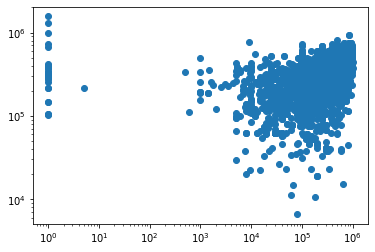

In [77]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.gca()
ax.scatter(Y_train,Y_train_pred)
ax.set_yscale('log')
ax.set_xscale('log')


In [78]:
print(min(Y_test))
print(max(Y_test))

1.0
995300.0


In [79]:
np.random.randint(0, 10, 9)

array([0, 5, 0, 3, 6, 9, 8, 6, 5])

In [80]:
len

<function len(obj, /)>

In [103]:
noise_pred = np.random.randint(min(Y_test),max(Y_test), size=len(Y_test))

In [104]:
print("R2 score on random noise : ", r2_score(Y_test, noise_pred))

R2 score on random noise :  -2.347330112653762


<AxesSubplot:title={'center':'Estimated costs by year'}, xlabel='Estimated Cost', ylabel='Count'>

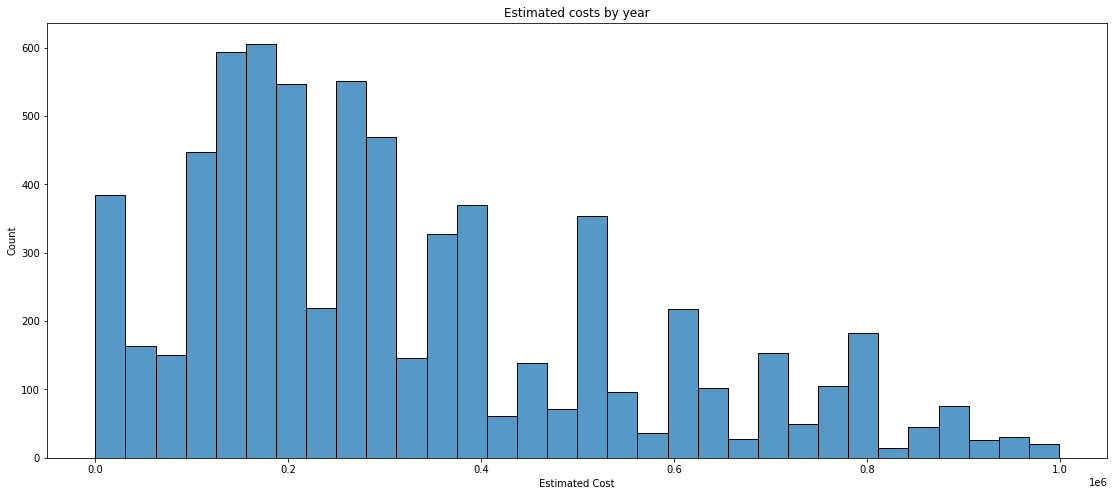

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(19,8))
# Add title
plt.title("Estimated costs by year")
sns.histplot(data=filtered_dataset, x ='Estimated Cost')

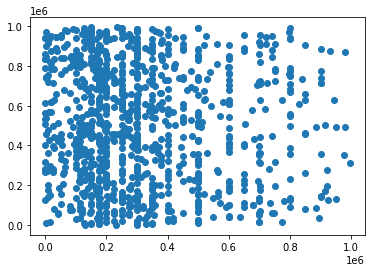

In [89]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.gca()
ax.scatter(Y_test,noise_pred)

In [85]:
r2_score?


Signature:
r2_score(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
    force_finite=True,
)
Docstring:
:math:`R^2` (coefficient of determination) regression score function.

Best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). In the general case when the true y is
non-constant, a constant model that always predicts the average y
disregarding the input features would get a :math:`R^2` score of 0.0.

In the particular case when ``y_true`` is constant, the :math:`R^2` score
is not finite: it is either ``NaN`` (perfect predictions) or ``-Inf``
(imperfect predictions). To prevent such non-finite numbers to pollute
higher-level experiments such as a grid search cross-validation, by default
these cases are replaced with 1.0 (perfect predictions) or 0.0 (imperfect
predictions) respectively. You can set ``force_finite`` to ``False`` to
prevent this fix from happening.

Note: when the prediction residuals hav